# transfer learning on Pre-trained Model for Patient_outcome
In this tutorial, we demonstrate how to fine-tune a pre-trained model on a new dataset for the cell type annotation task. We use the Multiple Sclerosis dataset as an example and fine-tune on the pre-trained whole-body model. Please download the dataset folder from https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing

We summarize the fine-tuning pipeline in the following steps, which can be used as a general recipe for finetuning on cell-type annotation tasks and beyond: 

     1. Specify hyper-parameter setup for integration task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. Finetune scGPT with task-specific objectives
     
     5. Evaluate fine-tuned scGPT

workflow: finetune model using CART data, label: T cell subset -> save model -> finetune on perturb --> predict few genes --> visualization 
possible label:
- patient outcome
- T cell subset annotation 

Generate an abstract 
think about what I need feedback on

In [1]:
# %%
%reload_ext autoreload
%autoreload 2
import copy
import gc
import json
import os
from pathlib import Path
import shutil
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import pickle
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from sklearn.metrics import confusion_matrix

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(6, 6))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

Global seed set to 0
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/bench-user/scGPT/Tcell_GPT/tutorials/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/home/bench-user/.apps/conda/envs/scGPT_env/lib/python3.10/site-p

## Step1: Specify hyper-parameter setup for cell-type annotation task
Listed below are some hyper-parameter recommendations for the cell-type task. Note that the CLS objective is on to facilitate cell-type classification.

In [2]:
hyperparameter_defaults = dict(
    seed=0,
    dataset_name="Good_og_data",#"clonotype_genes_filtered_counts_data",
    do_train=True,
    load_model="./scGPT_human_model",
    mask_ratio=0.0,
    epochs=3,
    n_bins=51,
    MVC=False, # Masked value prediction for cell embedding
    ecs_thres=0.0, # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=0.0,
    lr=1e-2,
    batch_size=8,
    layer_size=128,
    nlayers=4,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=4,  # number of heads in nn.MultiheadAttention
    dropout=0.2,  # dropout probability
    schedule_ratio=0.9,  # ratio of epochs for learning rate schedule
    save_eval_interval=5,
    fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    include_zero_gene = False,
    freeze = False, #freeze
    DSBN = False,  # Domain-spec batchnorm
    transfer_learning = True,
    layers_added = "3",
    finetune_layers = "top 2",
)

In [3]:
run = wandb.init(
    config=hyperparameter_defaults,
    project="transfer learning scGPT",
    # reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kristint (mackall_lab). Use `wandb login --relogin` to force relogin


{'seed': 0, 'dataset_name': 'Good_og_data', 'do_train': True, 'load_model': './scGPT_human_model', 'mask_ratio': 0.0, 'epochs': 3, 'n_bins': 51, 'MVC': False, 'ecs_thres': 0.0, 'dab_weight': 0.0, 'lr': 0.01, 'batch_size': 8, 'layer_size': 128, 'nlayers': 4, 'nhead': 4, 'dropout': 0.2, 'schedule_ratio': 0.9, 'save_eval_interval': 5, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'include_zero_gene': False, 'freeze': False, 'DSBN': False, 'transfer_learning': True, 'layers_added': '3', 'finetune_layers': 'top 2'}


In [4]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = "auto"  # for masked values, now it should always be auto

include_zero_gene = config.include_zero_gene  # if True, include zero genes among hvgs in the training
max_seq_len = 3001
n_bins = config.n_bins

# input/transfer representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"
output_style = "binned"  # "normed_raw", "log1p", or "binned"

# settings for training
MLM = False  # whether to use masked language modeling, currently it is always on.
CLS = False # celltype classification objective
ADV = False  # Adversarial training for batch correction
CCE = False  # Contrastive cell embedding objective
MVC = config.MVC  # Masked value prediction for cell embedding
ECS = config.ecs_thres > 0  # Elastic cell similarity objective
DAB = False  # Domain adaptation by reverse backpropagation, set to 2 for separate optimizer
INPUT_BATCH_LABELS = False  # TODO: have these help MLM and MVC, while not to classifier
input_emb_style = "continuous"  # "category" or "continuous" or "scaling"
cell_emb_style = "cls"  # "avg-pool" or "w-pool" or "cls"
adv_E_delay_epochs = 0  # delay adversarial training on encoder for a few epochs
adv_D_delay_epochs = 0
mvc_decoder_style = "inner product"
ecs_threshold = config.ecs_thres
dab_weight = config.dab_weight

explicit_zero_prob = MLM and include_zero_gene  # whether explicit bernoulli for zeros
do_sample_in_train = False and explicit_zero_prob  # sample the bernoulli in training

per_seq_batch_sample = False

# settings for optimizer
lr = config.lr  # TODO: test learning rate ratio between two tasks
lr_ADV = 1e-3  # learning rate for discriminator, used when ADV is True
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
schedule_interval = 1

# settings for the model
fast_transformer = config.fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"
embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# logging
log_interval = 100  # iterations
save_eval_interval = config.save_eval_interval  # epochs
do_eval_scib_metrics = True

In [5]:
# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert output_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]
if input_style == "binned":
    if input_emb_style == "scaling":
        raise ValueError("input_emb_style `scaling` is not supported for binned input.")
elif input_style == "log1p" or input_style == "normed_raw":
    if input_emb_style == "category":
        raise ValueError(
            "input_emb_style `category` is not supported for log1p or normed_raw input."
        )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins

if ADV and DAB:
    raise ValueError("ADV and DAB cannot be both True.")
DAB_separate_optim = True if DAB > 1 else False

In [6]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/dev_Good_og_data-Aug15-03-19


In [7]:
Path.cwd()

PosixPath('/home/bench-user/scGPT/Tcell_GPT/tutorials')

588 TCR/BCR clonotype, MT and sex genes removed

In [8]:
import anndata as ad
# Tcell_hvgs = ad.read_h5ad("Tcell_hvgs_clono_MT_sex_genes_rm.h5ad")
Good_data = ad.read_h5ad("Good_og_data_clono_MT_filteres.h5ad")

In [9]:
Good_data

AnnData object with n_obs × n_vars = 20205 × 36016
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'Age', 'Sex', 'High_LDH', 'Response_3m', 'Max_CRS', 'Max_ICANS'
    var: 'gene_name'
    uns: 'Response_3m_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [10]:
sc.pp.highly_variable_genes(Good_data, n_top_genes=3000, inplace=True)

In [11]:
Good_hvgs = Good_data[:, Good_data.var["highly_variable"]].copy()   
Good_hvgs

AnnData object with n_obs × n_vars = 20205 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'Age', 'Sex', 'High_LDH', 'Response_3m', 'Max_CRS', 'Max_ICANS'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'pca', 'umap', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
Good_hvgs.obs.Response_3m.value_counts()

Response_3m
NR    14630
OR     5575
Name: count, dtype: int64

In [13]:
# method 1: randomly spliting
def ref_query_split(Tcell_data, seed_num, split_ratio):
    patient_list = Tcell_data.obs["patient_id"].unique()
    np.random.seed(seed_num)
    reference_patients = np.random.choice(patient_list, size=int(len(patient_list) * split_ratio), replace=False)
    reference_adata = Tcell_data[Tcell_data.obs['patient_id'].isin(reference_patients)]   
    query_adata = Tcell_data[~Tcell_data.obs['patient_id'].isin(reference_patients)]  
    return reference_adata, query_adata

In [14]:
# ref_adata, query_adata = ref_query_split(Tcell_hvgs, 1, 0.8)

In [15]:
ref_adata, query_adata = ref_query_split(Good_hvgs, 1, 0.8)

In [16]:
ref_adata.obs.Response_3m.value_counts(), query_adata.obs.Response_3m.value_counts()

(Response_3m
 NR    12960
 OR     4326
 Name: count, dtype: int64,
 Response_3m
 NR    1670
 OR    1249
 Name: count, dtype: int64)

In [17]:
from imblearn.over_sampling import SMOTE
X_trn = ref_adata.X.toarray()
y_train = ref_adata.obs.Response_3m

sm = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = sm.fit_resample(X_trn, y_train)

In [18]:
X_train_resampled.shape, y_train_resampled.shape
# ref_adata.layers["counts"] = X_train_resampled
# ref_adata.obs["Response_3m"] = y_train_resampled

((25920, 3000), (25920,))

In [19]:
train_adata = ad.AnnData(X=X_train_resampled, obs=y_train_resampled.to_frame(), var=ref_adata.var)
train_adata

AnnData object with n_obs × n_vars = 25920 × 3000
    obs: 'Response_3m'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [20]:
# pca
sc.tl.pca(train_adata, svd_solver="arpack")
sc.pp.neighbors(train_adata, use_rep="X_pca", n_neighbors=15, metric="cosine")
sc.tl.umap(train_adata)

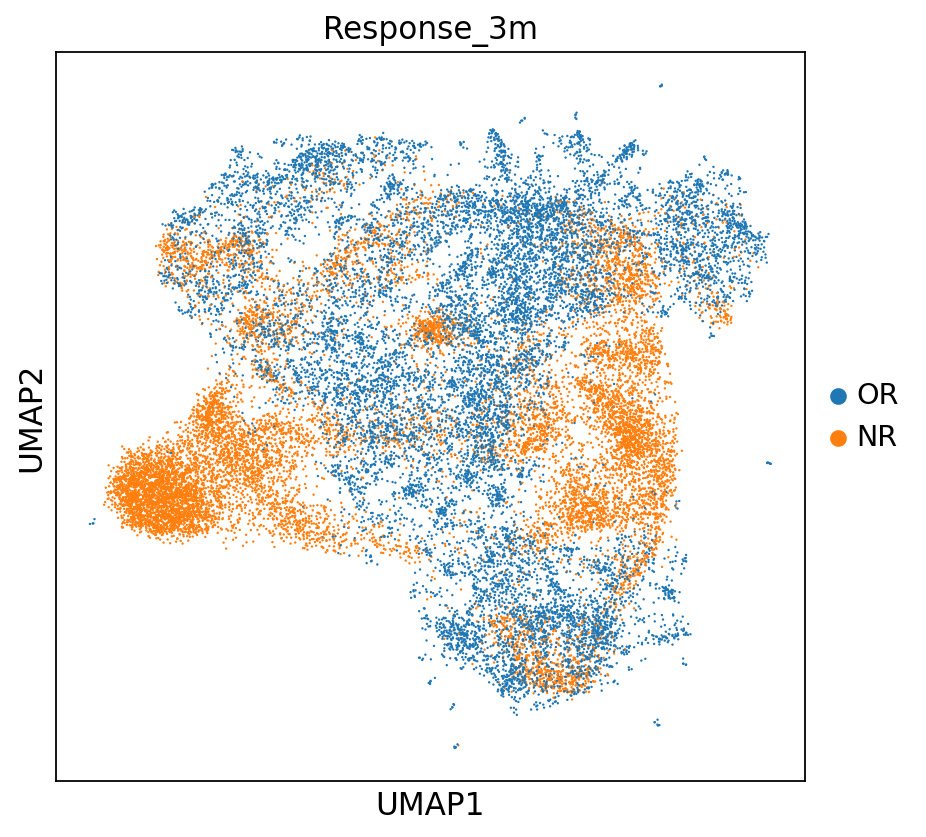

In [21]:
sc.pl.umap(train_adata, color="Response_3m")

In [22]:
aug_adata = train_adata.copy()

In [23]:
ref_adata.X

<17286x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 4363214 stored elements in Compressed Sparse Row format>

In [24]:
# convert to sparse matrix
from scipy.sparse import csr_matrix 
aug_adata.X = csr_matrix(aug_adata.X)

In [25]:
aug_adata.var

,gene_name,highly_variable,means,dispersions,dispersions_norm
AL627309.5,AL627309.5,True,0.019502,1.912074,0.996057
FAM87B,FAM87B,True,0.000934,1.978241,1.074373
AGRN,AGRN,True,0.020370,2.101632,1.220421
TNFRSF18,TNFRSF18,True,0.759151,1.618755,0.943288
TNFRSF4,TNFRSF4,True,1.307527,2.205387,2.295088
...,...,...,...,...,...
KDM5D,KDM5D,True,0.119878,2.222788,1.363823
AC010889.2,AC010889.2,True,0.003846,2.113953,1.235004
TTTY10,TTTY10,True,0.010267,1.898685,0.980209
AL354822.1,AL354822.1,True,0.026863,2.013880,1.116555


In [26]:
aug_adata.X.mean(), aug_adata.X.min(), aug_adata.X.max()    

(0.11371939929013021, 0.0, 7.593150496734349)

In [27]:
aug_adata.obs.Response_3m.value_counts()

Response_3m
OR    12960
NR    12960
Name: count, dtype: int64

## Step 2: Load and pre-process data
We follow the standard scGPT data pre-processing pipelines for the cell-type annotation task. Note that since now we have two datasets at hand (i.e., reference and query data), the same pre-prpocessing steps need to be applied to both of them.

In [28]:
if dataset_name == "Good_og_data":
    # data_dir = Path("./sample_data_cell_ann")
    adata = aug_adata
    adata_test = query_adata
    adata.obs["Response_3m"] = adata.obs["Response_3m"].astype("category")
    adata_test.obs["Response_3m"] = adata_test.obs["Response_3m"].astype("category")
    adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
    adata_test.obs["batch_id"]  = adata_test.obs["str_batch"] = "1"          
    # adata.var.set_index("gene_name", inplace=True) # using gene name directly as index
    # fixed typo here adata_test.var instead of adata.var
    # adata_test.var.set_index("gene_name", inplace=True)
    data_is_raw = False
    filter_gene_by_counts = False
    adata_test_raw = adata_test.copy()
    adata = adata.concatenate(adata_test, batch_key="str_batch") # concatenate reference and query data
                
# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
response_id_labels = adata.obs["Response_3m"].astype("category").cat.codes.values #convert categories into integers
response = adata.obs["Response_3m"].unique()
num_types = len(np.unique(response_id_labels))
id2type = dict(enumerate(adata.obs["Response_3m"].astype("category").cat.categories))
adata.obs["response_id"] = response_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [29]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt" # Path.cwd() / "best_finetuned_models/finetuned_generative_task_state_dict.pth" 
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]

scGPT - INFO - match 2015/3000 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from scGPT_human_model/best_model.pt, the model args will override the config scGPT_human_model/args.json.


In [30]:
adata.var.gene_name

FAM87B        FAM87B
AGRN            AGRN
TNFRSF18    TNFRSF18
TNFRSF4      TNFRSF4
C1QTNF12    C1QTNF12
              ...   
NLGN4Y        NLGN4Y
FAM224B      FAM224B
TTTY14        TTTY14
KDM5D          KDM5D
TTTY10        TTTY10
Name: gene_name, Length: 2015, dtype: object

In [31]:
adata.X.mean(), adata.X.min(), adata.X.max()

(0.16604347324050184, 0.0, 7.593150496734349)

In [32]:
adata.obs.Response_3m.value_counts(), adata_test.obs.Response_3m.value_counts()

(Response_3m
 NR    14630
 OR    14209
 Name: count, dtype: int64,
 Response_3m
 NR    1670
 OR    1249
 Name: count, dtype: int64)

In [33]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]

preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)

scGPT - INFO - Binning data ...
scGPT - INFO - Binning data ...


In [34]:
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

response_labels = adata.obs["response_id"].tolist()  # make sure count from 0
response_labels = np.array(response_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_response_labels, 
    valid_response_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, response_labels, batch_ids, test_size=0.2, shuffle=True
)

In [35]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [36]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=include_zero_gene,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=include_zero_gene,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 20736, 
	 feature length: 936
scGPT - INFO - valid set number of samples: 5184, 
	 feature length: 934


In [37]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    tensor_response_labels_train = torch.from_numpy(train_response_labels).long()
    tensor_response_labels_valid = torch.from_numpy(valid_response_labels).long()

    if sort_seq_batch:  # TODO: update to random pick seq source in each traning batch
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]
        tensor_response_labels_train = tensor_response_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]
        tensor_response_labels_valid = tensor_response_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
        "response_labels": tensor_response_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
        "response_labels": tensor_response_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader


## Step 3: Load the pre-trained scGPT model

In [38]:
import importlib
import scgpt.model
importlib.reload(scgpt.model)

# Verify that the changes have been loaded
print(scgpt.model.TransformerModel.__init__.__code__.co_varnames)

('self', 'ntoken', 'd_model', 'nhead', 'd_hid', 'nlayers', 'nlayers_cls', 'n_cls', 'vocab', 'dropout', 'pad_token', 'pad_value', 'do_mvc', 'do_dab', 'use_batch_labels', 'num_batch_labels', 'domain_spec_batchnorm', 'input_emb_style', 'n_input_bins', 'cell_emb_style', 'mvc_decoder_style', 'ecs_threshold', 'explicit_zero_prob', 'use_fast_transformer', 'fast_transformer_backend', 'pre_norm', 'transfer_learning', 'transfer_hidden_dim', 'transfer_dropout', 'use_affine', 'encoder_layers')


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=num_types if CLS else 1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=MVC,
    do_dab=DAB,
    use_batch_labels=INPUT_BATCH_LABELS,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    mvc_decoder_style=mvc_decoder_style,
    ecs_threshold=ecs_threshold,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,

    ## transfer learning
    transfer_learning=True,
    transfer_hidden_dim = 256,
    transfer_dropout = 0.2,
)
if config.load_model is not None:
    try:
        # model.load_state_dict(state_dict)
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Freeze all pre-decoder weights
for name, para in model.named_parameters():
    print("-"*20)
    print(f"name: {name}")
    if config.freeze and "encoder" in name and "transformer_encoder" not in name:
    # if config.freeze and "encoder" in name:
        print(f"freezing weights for: {name}")
        para.requires_grad = False

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

logger.info(f"Total Pre freeze Params {(pre_freeze_param_count )}")
logger.info(f"Total Post freeze Params {(post_freeze_param_count )}")
wandb.log(
        {
            "info/pre_freeze_param_count": pre_freeze_param_count,
            "info/post_freeze_param_count": post_freeze_param_count,
        },
)

model.to(device)
wandb.watch(model)

if ADV:
    discriminator = AdversarialDiscriminator(
        d_model=embsize,
        n_cls=num_batch_types,
    ).to(device)


scGPT - INFO - Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
scGPT - INFO - Loading params encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
scGPT - INFO - Loading params value_encoder.linear1.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params value_encoder.linear2.bias with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.weight with shape torch.Size([512])
scGPT - INFO - Loading params value_encoder.norm.bias with shape torch.Size([512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
scGPT - INFO - Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Si

In [40]:
def freeze_layers(model):
    for name, param in model.named_parameters():
        if name.startswith("transfer_classifier"):
            param.requires_grad = True
        elif name.startswith("transformer_encoder.layers.10") or name.startswith("transformer_encoder.layers.11"):
            param.requires_grad = True

        else:
            param.requires_grad = False

def freeze_all_layers(model):
    for name, param in model.named_parameters():
        if name.startswith("transfer_classifier"):
            param.requires_grad = True
        else:
            param.requires_grad = False



def unfreeze_all_parameters(model):
    for param in model.parameters():
        param.requires_grad = True

In [41]:
# freeze_layers(model)
#unfreeze_all_parameters(model) # classified all as OR

freeze_all_layers(model)




In [42]:
def verify_freezing(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Trainable: {name}")
        else:
            print(f"Frozen: {name}")

# freeze_original_model(model)
verify_freezing(model)

Trainable: transfer_classifier.0.weight
Trainable: transfer_classifier.0.bias
Trainable: transfer_classifier.3.weight
Trainable: transfer_classifier.3.bias
Trainable: transfer_classifier.6.weight
Trainable: transfer_classifier.6.bias
Frozen: encoder.embedding.weight
Frozen: encoder.enc_norm.weight
Frozen: encoder.enc_norm.bias
Frozen: value_encoder.linear1.weight
Frozen: value_encoder.linear1.bias
Frozen: value_encoder.linear2.weight
Frozen: value_encoder.linear2.bias
Frozen: value_encoder.norm.weight
Frozen: value_encoder.norm.bias
Frozen: transformer_encoder.layers.0.self_attn.in_proj_weight
Frozen: transformer_encoder.layers.0.self_attn.in_proj_bias
Frozen: transformer_encoder.layers.0.self_attn.out_proj.weight
Frozen: transformer_encoder.layers.0.self_attn.out_proj.bias
Frozen: transformer_encoder.layers.0.linear1.weight
Frozen: transformer_encoder.layers.0.linear1.bias
Frozen: transformer_encoder.layers.0.linear2.weight
Frozen: transformer_encoder.layers.0.linear2.bias
Frozen: tra

In [43]:
# ######################## original ############################
# criterion = masked_mse_loss
# criterion_cls = nn.CrossEntropyLoss()
# criterion_dab = nn.CrossEntropyLoss()
# criterion_transfer = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=lr, eps=1e-4 if config.amp else 1e-8
# )
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, schedule_interval, gamma=config.schedule_ratio
# )
# if DAB_separate_optim:
#     optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler_dab = torch.optim.lr_scheduler.StepLR(
#         optimizer_dab, schedule_interval, gamma=config.schedule_ratio
#     )
# if ADV:
#     criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
#     optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
#     scheduler_E = torch.optim.lr_scheduler.StepLR(
#         optimizer_E, schedule_interval, gamma=config.schedule_ratio
#     )
#     optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
#     scheduler_D = torch.optim.lr_scheduler.StepLR(
#         optimizer_D, schedule_interval, gamma=config.schedule_ratio
#     )

# scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [54]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()

# new criterion for transfer learning
criterion_transfer = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.8).to(device))

# Separate parameters for transfer learning classifier
transfer_params = [p for n, p in model.named_parameters() if "transfer_classifier" in n]
og_params = [p for n, p in model.named_parameters() if "transfer_classifier" not in n]


optimizer = torch.optim.AdamW(
    [
        {"params": og_params, "lr": lr, "weight_decay": 0.01}, # lower lr for pre-trained weights
        {"params": transfer_params, "lr": lr, "weight_decay": 0.01} # higher lr for transfer learning classifier
    ],
    eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, schedule_interval, gamma=config.schedule_ratio
)
if DAB_separate_optim:
    optimizer_dab = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler_dab = torch.optim.lr_scheduler.StepLR(
        optimizer_dab, schedule_interval, gamma=config.schedule_ratio
    )
if ADV:
    criterion_adv = nn.CrossEntropyLoss()  # consider using label smoothing
    optimizer_E = torch.optim.Adam(model.parameters(), lr=lr_ADV)
    scheduler_E = torch.optim.lr_scheduler.StepLR(
        optimizer_E, schedule_interval, gamma=config.schedule_ratio
    )
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_ADV)
    scheduler_D = torch.optim.lr_scheduler.StepLR(
        optimizer_D, schedule_interval, gamma=config.schedule_ratio
    )

scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [64]:
############################## no gradient accumulation ############################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score
import numpy as np
import wandb
import time
import copy
from tqdm import tqdm
import logging


logger = logging.getLogger(__name__)

def check_param_change(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data.mean().item():.5f}")

def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    
    total_loss = 0.0
    
    all_preds = []
    all_labels = [] 
    
    start_time = time.time()
    num_batches = len(loader)

    print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")

    # unpack the data loader
    for batch_idx, batch_data in enumerate(tqdm(loader, desc="Training")):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)
        response_labels = batch_data["response_labels"].to(device).float()

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])

        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                CLS=False,
                CCE=False,
                MVC=False,
                ECS=False,
                do_sample=do_sample_in_train,
            )
            masked_positions = input_values.eq(mask_value)
            loss = 0.0
            metrics_to_log = {}
            
            if CLS:
                loss_cls = criterion_cls(output_dict["cls_output"], response_labels)
                loss = loss + loss_cls
                metrics_to_log.update({"train/cls": loss_cls.item()})

                error_rate = 1 - (
                    (output_dict["cls_output"].argmax(1) == response_labels)
                    .sum()
                    .item()
                ) / response_labels.size(0)

            transfer_output_logits = output_dict["transfer_output"].squeeze(-1).float() #.argmax(1).float()
            loss = criterion_transfer(transfer_output_logits, response_labels)
            metrics_to_log.update({"train/transfer": loss.item()})

            # error_rate = 1 - (output_dict["transfer_output"].argmax(1) == response_labels).sum().item() / response_labels.size(0)

            # print(loss.requires_grad) # check if the loss is requiring grad
            # # Check if these tensors require gradients
            # print(transfer_output_logits.requires_grad)  # Should be True
            # print(response_labels.requires_grad)  


        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
    
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()
        

        total_loss += loss.item()
        preds = torch.sigmoid(transfer_output_logits)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(response_labels.cpu().numpy())
    
    wandb.log(metrics_to_log)

    # total_error += error_rate

    # if batch % log_interval == 0 and batch > 0:
    #     lr = scheduler.get_last_lr()[0]
    #     cur_loss = total_loss / log_interval
    #     elapsed = time.time() - start_time
        
    #     logger.info(
    #         f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | ms/batch {elapsed * 1000 / log_interval:.2f} | loss {cur_loss:.4f} | error rate {total_error / log_interval:.4f}"
    #     )
        
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels).astype(int)

    binary_preds = (all_preds > 0.5).astype(int)

    epoch_loss = total_loss / num_batches
    epoch_accuracy = accuracy_score(all_labels, binary_preds)
    epoch_f1 = f1_score(all_labels, binary_preds, average='binary')

    print(f"Final learning rate: {optimizer.param_groups[0]['lr']}")

    wandb.log({
        "train/loss": epoch_loss,
        "train/accuracy": epoch_accuracy,
        "train/f1": epoch_f1,
    })

def define_wandb_metrics():
    wandb.define_metric("valid/loss", summary="min", step_metric="epoch")
    wandb.define_metric("valid/accuracy", summary="max", step_metric="epoch")
    wandb.define_metric("valid/f1", summary="max", step_metric="epoch")

def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data in tqdm(loader, desc="Evaluating"):
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)
            response_labels = batch_data["response_labels"].to(device).float()

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
                    CLS=False,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=do_sample_in_train,
                    #generative_training = False,
                )
                output_values = output_dict["transfer_output"].squeeze(-1) #.argmax(1).float() #squeeze(-1) 
                output_values = output_values
                loss = criterion_transfer(output_values, response_labels)

                if DAB:
                    loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            # accuracy = (output_values.argmax(1) == response_labels).sum().item()
            # total_error += (1 - accuracy / len(response_labels))
            preds = torch.sigmoid(output_values) #output_values.argmax(1).cpu().numpy() 
            
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(response_labels.cpu().numpy())

            # error_rate = 1 - (output_dict["transfer_output"].argmax(1) == response_labels).sum().item() / response_labels.size(0)


        # Convert lists to numpy arrays
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels).astype(int)

        
        # convert preds to 0 or 1
        binary_preds = (all_preds > 0.5).astype(int)

        val_loss = total_loss / len(loader.dataset) 
        val_accuracy = accuracy_score(all_labels, binary_preds)
        precision = precision_score(all_labels, binary_preds, average='binary')
        recall = recall_score(all_labels, binary_preds, average='binary')
        val_f1 = f1_score(all_labels, binary_preds, average='binary')
        cm = confusion_matrix(all_labels, binary_preds)
        roc_auc = roc_auc_score(all_labels, all_preds)
            

        # put results in a dictionary
        results = {
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_f1": val_f1,
            "precision": precision,
            "recall": recall,
            "cm": cm,
            "roc_auc": roc_auc,
            # "average error": total_error/len(loader.dataset),
            
            # "binary_preds": binary_preds,
            # "all_preds": all_preds,
        }

        # Print validation metrics
        # logger.info(f"Validation Loss: {val_loss:.4f}")
        # logger.info(f"Validation Accuracy: {val_accuracy:.4f}")
        # logger.info(f"Validation F1 Score: {val_f1:.4f}")
        # logger.info(f"Validation Precision: {precision:.4f}")
        # logger.info(f"Validation Recall: {recall:.4f}")

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {val_f1:.4f}")
        print(f"Confusion Matrix:\n{cm}")

    wandb.log(
        {
            "valid/loss": val_loss,
            "valid/accuracy": val_accuracy,
            "valid/f1": val_f1,
            "valid/precision": precision,
            "valid/recall": recall,
            "epoch": epoch,
        },
    )

    

    if return_raw:
        return results, all_preds
    # else:
    return results #val_f1, val_accuracy, cm, val_loss, all_preds


In [46]:
# ################################### gradient accumulation ########################################
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
# import numpy as np
# import wandb
# import time
# import copy
# from tqdm import tqdm
# import logging

# logger = logging.getLogger(__name__)

# def check_param_change(model):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"{name}: {param.data.mean().item():.5f}")

# def train(model: nn.Module, loader: DataLoader, accumulation_steps: int = 4) -> None:
#     """
#     Train the model for one epoch.
#     """
#     model.train()
    
#     total_loss = 0.0
    
#     all_preds = []
#     all_labels = [] 
    
#     start_time = time.time()
#     num_batches = len(loader)

#     print(f"Initial learning rate: {optimizer.param_groups[0]['lr']}")



#     # unpack the data loader
#     for batch_idx, batch_data in enumerate(tqdm(loader, desc="Training")):
#         input_gene_ids = batch_data["gene_ids"].to(device)
#         input_values = batch_data["values"].to(device)
#         batch_labels = batch_data["batch_labels"].to(device)
#         response_labels = batch_data["response_labels"].to(device).float()


#         src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
#         # if batch_idx % 100 ==0:
#         #     check_param_change(model) # check if parameters are changing
#         with torch.cuda.amp.autocast(enabled=config.amp): #forward pass with autocast for mixed precision
#             output_dict = model(
#                 input_gene_ids,
#                 input_values,
#                 src_key_padding_mask=src_key_padding_mask,
#                 batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
#                 # transfer_mode = True, # enable transfer mode
#                 CLS=False, # disable original tasks during transfer learning
#                 CCE=False,
#                 MVC=False,
#                 ECS=False,
#                 do_sample=do_sample_in_train,
#                 #generative_training=False
#             )
#             masked_positions = input_values.eq(mask_value)  # the postions to predict
#             loss = 0.0
#             metrics_to_log = {}
            
#             if CLS:
#                 loss_cls = criterion_cls(output_dict["cls_output"], response_labels)
#                 loss = loss + loss_cls
#                 metrics_to_log.update({"train/cls": loss_cls.item()})

#                 error_rate = 1 - (
#                     (output_dict["cls_output"].argmax(1) == response_labels)
#                     .sum()
#                     .item()
#                 ) / response_labels.size(0)

#             #if transfer_learning:
#                 # transfer learning loss
#             transfer_output_logits = output_dict["transfer_output"].argmax(1) #squeeze(-1)
#             # transfer_output_logits = transfer_output_logits.float()
#             loss = criterion_transfer(transfer_output_logits, response_labels)
#             loss = loss / accumulation_steps
        

            
        

        
#         scaler.scale(loss).backward()
#         # Gradient accumulation
#         if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(loader):
#             scaler.unscale_(optimizer) # unscale the gradients
        
#             with warnings.catch_warnings(record=True) as w:
#                 warnings.filterwarnings("always")
#                 torch.nn.utils.clip_grad_norm_(
#                     model.parameters(),
#                     1.0,
#                     error_if_nonfinite=False if scaler.is_enabled() else True,
#                 )
#                 if len(w) > 0:
#                     logger.warning(
#                         f"Found infinite gradient. This may be caused by the gradient "
#                         f"scaler. The current scale is {scaler.get_scale()}. This warning "
#                         "can be ignored if no longer occurs after autoscaling of the scaler."
#                     )
#             scaler.step(optimizer) #  apply to optimizer
#             scaler.update() # update scale for next iteration
#             optimizer.zero_grad()

#         total_loss += loss.item() * accumulation_steps # add un-normalized loss
#         preds = torch.sigmoid(transfer_output_logits)
#         all_preds.extend(preds.detach().cpu().numpy())
#         all_labels.extend(response_labels.cpu().numpy())

#     # Convert lists to numpy arrays
#     all_preds = np.array(all_preds)
#     all_labels = np.array(all_labels)

#     # convert preds to 0 or 1
#     # binary_preds = (all_preds > 0.5).astype(int)


#     epoch_loss = total_loss / num_batches
#     epoch_accuracy = accuracy_score(all_labels, all_preds) #binary_preds)
#     epoch_f1 = f1_score(all_labels, all_preds) #binary_preds)

#     print(f"Final learning rate: {optimizer.param_groups[0]['lr']}")
#     # check_param_change(model)  # Check parameters at the end of the epoch

#     wandb.log({
#         "train/loss": epoch_loss,
#         "train/accuracy": epoch_accuracy,
#         "train/f1": epoch_f1,
#     })
    

# def define_wandb_metrics():
#     wandb.define_metric("valid/loss", summary="min", step_metric="epoch")
#     wandb.define_metric("valid/accuracy", summary="max", step_metric="epoch")
#     wandb.define_metric("valid/f1", summary="max", step_metric="epoch")

# def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
#     """
#     Evaluate the model on the evaluation data.
#     """
#     model.eval()
#     total_loss = 0.0
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for batch_data in tqdm(loader, desc="Evaluating"):
#             input_gene_ids = batch_data["gene_ids"].to(device)
#             input_values = batch_data["values"].to(device)
#             batch_labels = batch_data["batch_labels"].to(device)
#             response_labels = batch_data["response_labels"].to(device).float()

#             src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
#             with torch.cuda.amp.autocast(enabled=config.amp):
#                 output_dict = model(
#                     input_gene_ids,
#                     input_values,
#                     src_key_padding_mask=src_key_padding_mask,
#                     batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
#                     CLS=False,  # evaluation does not need CLS or CCE
#                     CCE=False,
#                     MVC=False,
#                     ECS=False,
#                     do_sample=do_sample_in_train,
#                     #generative_training = False,
#                 )
#                 transfer_output_logits = output_dict["transfer_output"].argmax(1) #squeeze(-1) 
#                 # transfer_output_logits = transfer_output_logits.float()
#                 loss = criterion_transfer(transfer_output_logits, response_labels)

#                 if DAB:
#                     loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

#             total_loss += loss.item() * len(input_gene_ids)
#             preds = torch.sigmoid(transfer_output_logits)
#             all_preds.extend(preds.detach().cpu().numpy())
#             all_labels.extend(response_labels.cpu().numpy())


#         # Convert lists to numpy arrays
#         all_preds = np.array(all_preds)
#         all_labels = np.array(all_labels)
#         # convert preds to 0 or 1
#         # binary_preds = (all_preds > 0.5).astype(int)

#         val_loss = total_loss / len(loader.dataset) 
#         val_accuracy = accuracy_score(all_labels, all_preds) # binary_preds)
#         precision = precision_score(all_labels,all_preds) #  binary_preds)
#         recall = recall_score(all_labels,all_preds) #  binary_preds)
#         val_f1 = f1_score(all_labels, all_preds) # binary_preds)
#         cm = confusion_matrix(all_labels, all_preds) #  binary_preds)
        

#         # put results in a dictionary
#         results = {
#             "val_loss": val_loss,
#             "val_accuracy": val_accuracy,
#             "val_f1": val_f1,
#             "precision": precision,
#             "recall": recall,
#             "cm": cm,
#             # "binary_preds": binary_preds,
#             # "all_preds": all_preds,
#         }

#         # Print validation metrics
#         logger.info(f"Validation Loss: {val_loss:.4f}")
#         logger.info(f"Validation Accuracy: {val_accuracy:.4f}")
#         logger.info(f"Validation F1 Score: {val_f1:.4f}")
#         logger.info(f"Validation Precision: {precision:.4f}")
#         logger.info(f"Validation Recall: {recall:.4f}")

#     wandb.log(
#         {
#             "valid/loss": val_loss,
#             "valid/accuracy": val_accuracy,
#             "valid/f1": val_f1,
#             "valid/precision": precision,
#             "valid/recall": recall,
#             "epoch": epoch,
#         },
#     )

    

#     if return_raw:
#         return results, binary_preds, all_preds
#     # else:
#     return results #val_f1, val_accuracy, cm, val_loss, all_preds


In [47]:
# ########################### original ############################
# def train(model: nn.Module, loader: DataLoader) -> None:
#     """
#     Train the model for one epoch.
#     """
#     model.train()
#     (
#         total_loss,
#         total_mse,
#         total_cls,
#         total_cce,
#         total_mvc,
#         total_ecs,
#         total_dab,
#         total_adv_E,
#         total_adv_D,
#         total_zero_log_prob,
#         total_mvc_zero_log_prob,
#     ) = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
#     total_error = 0.0
#     start_time = time.time()

#     num_batches = len(loader)
#     for batch, batch_data in enumerate(loader):
#         input_gene_ids = batch_data["gene_ids"].to(device)
#         input_values = batch_data["values"].to(device)
#         target_values = batch_data["target_values"].to(device)
#         batch_labels = batch_data["batch_labels"].to(device)
#         response_labels = batch_data["response_labels"].to(device)

#         src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
#         with torch.cuda.amp.autocast(enabled=config.amp):
#             output_dict = model(
#                 input_gene_ids,
#                 input_values,
#                 src_key_padding_mask=src_key_padding_mask,
#                 batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
#                 CLS=True,
#                 CCE=CCE,
#                 MVC=MVC,
#                 ECS=ECS,
#                 do_sample=do_sample_in_train,
                
#                 #generative_training=False
#             )

#             masked_positions = input_values.eq(mask_value)  # the postions to predict
#             loss = 0.0
#             metrics_to_log = {}
#             if MLM:
#                 loss_mse = criterion(
#                     output_dict["mlm_output"], target_values, masked_positions
#                 )
#                 loss = loss + loss_mse
#                 metrics_to_log = {"train/mse": loss_mse.item()}
#             if explicit_zero_prob:
#                 loss_zero_log_prob = criterion_neg_log_bernoulli(
#                     output_dict["mlm_zero_probs"], target_values, masked_positions
#                 )
#                 loss = loss + loss_zero_log_prob
#                 metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
#             if CLS:
#                 loss_cls = criterion_cls(output_dict["cls_output"], response_labels)
#                 loss = loss + loss_cls
#                 metrics_to_log.update({"train/cls": loss_cls.item()})

#                 error_rate = 1 - (
#                     (output_dict["cls_output"].argmax(1) == response_labels)
#                     .sum()
#                     .item()
#                 ) / response_labels.size(0)
#             if CCE:
#                 loss_cce = 10 * output_dict["loss_cce"]
#                 loss = loss + loss_cce
#                 metrics_to_log.update({"train/cce": loss_cce.item()})
#             if MVC:
#                 loss_mvc = criterion(
#                     output_dict["mvc_output"], target_values, masked_positions
#                 )
#                 loss = loss + loss_mvc
#                 metrics_to_log.update({"train/mvc": loss_mvc.item()})
#             if MVC and explicit_zero_prob:
#                 loss_mvc_zero_log_prob = criterion_neg_log_bernoulli(
#                     output_dict["mvc_zero_probs"], target_values, masked_positions
#                 )
#                 loss = loss + loss_mvc_zero_log_prob
#                 metrics_to_log.update({"train/mvc_nzlp": loss_mvc_zero_log_prob.item()})
#             if ECS:
#                 loss_ecs = 10 * output_dict["loss_ecs"]
#                 loss = loss + loss_ecs
#                 metrics_to_log.update({"train/ecs": loss_ecs.item()})
#             if DAB:
#                 # try weighting and separate optimizer
#                 loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
#                 loss = loss + dab_weight * loss_dab
#                 metrics_to_log.update({"train/dab": loss_dab.item()})

#         model.zero_grad()
#         scaler.scale(loss).backward()
#         scaler.unscale_(optimizer)
#         with warnings.catch_warnings(record=True) as w:
#             warnings.filterwarnings("always")
#             torch.nn.utils.clip_grad_norm_(
#                 model.parameters(),
#                 1.0,
#                 error_if_nonfinite=False if scaler.is_enabled() else True,
#             )
#             if len(w) > 0:
#                 logger.warning(
#                     f"Found infinite gradient. This may be caused by the gradient "
#                     f"scaler. The current scale is {scaler.get_scale()}. This warning "
#                     "can be ignored if no longer occurs after autoscaling of the scaler."
#                 )
#         scaler.step(optimizer)
#         scaler.update()

#         if ADV:
#             # rerun the model for adversarial training
#             output_dict = model(
#                 input_gene_ids,
#                 input_values,
#                 src_key_padding_mask=src_key_padding_mask,
#                 batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
#                 CLS=CLS,
#                 CCE=CCE,
#                 MVC=MVC,
#                 ECS=ECS,
#                 do_sample=do_sample_in_train,
#                 #generative_training=False
#             )

#             # TRAINING DISCRIMINATOR
#             loss_adv_D = criterion_adv(
#                 discriminator(output_dict["cell_emb"].detach()), batch_labels
#             )
#             if epoch > adv_D_delay_epochs:
#                 discriminator.zero_grad()
#                 loss_adv_D.backward()
#                 optimizer_D.step()

#             # TRAINING ENCODER
#             loss_adv_E = -criterion_adv(
#                 discriminator(output_dict["cell_emb"]), batch_labels
#             )
#             # NOTE: the loss is negative here because we want to maximize
#             # the cross_entropy_loss, in other words, disguise against the discriminator
#             if epoch > adv_E_delay_epochs:
#                 model.zero_grad()
#                 discriminator.zero_grad()
#                 loss_adv_E.backward()
#                 optimizer_E.step()

#         wandb.log(metrics_to_log)

#         total_loss += loss.item()
#         total_mse += loss_mse.item() if MLM else 0.0
#         total_cls += loss_cls.item() if CLS else 0.0
#         total_cce += loss_cce.item() if CCE else 0.0
#         total_mvc += loss_mvc.item() if MVC else 0.0
#         total_ecs += loss_ecs.item() if ECS else 0.0
#         total_dab += loss_dab.item() if DAB else 0.0
#         total_adv_E += loss_adv_E.item() if ADV else 0.0
#         total_adv_D += loss_adv_D.item() if ADV else 0.0
#         total_zero_log_prob += loss_zero_log_prob.item() if explicit_zero_prob else 0.0
#         total_mvc_zero_log_prob += (
#             loss_mvc_zero_log_prob.item() if MVC and explicit_zero_prob else 0.0
#         )
#         total_error += error_rate
#         if batch % log_interval == 0 and batch > 0:
#             lr = scheduler.get_last_lr()[0]
#             ms_per_batch = (time.time() - start_time) * 1000 / log_interval
#             cur_loss = total_loss / log_interval
#             cur_mse = total_mse / log_interval
#             cur_cls = total_cls / log_interval if CLS else 0.0
#             cur_cce = total_cce / log_interval if CCE else 0.0
#             cur_mvc = total_mvc / log_interval if MVC else 0.0
#             cur_ecs = total_ecs / log_interval if ECS else 0.0
#             cur_dab = total_dab / log_interval if DAB else 0.0
#             cur_adv_E = total_adv_E / log_interval if ADV else 0.0
#             cur_adv_D = total_adv_D / log_interval if ADV else 0.0
#             cur_zero_log_prob = (
#                 total_zero_log_prob / log_interval if explicit_zero_prob else 0.0
#             )
#             cur_mvc_zero_log_prob = (
#                 total_mvc_zero_log_prob / log_interval
#                 if MVC and explicit_zero_prob
#                 else 0.0
#             )
#             cur_error = total_error / log_interval
#             # ppl = math.exp(cur_loss)
#             logger.info(
#                 f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
#                 f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
#                 f"loss {cur_loss:5.2f} | "
#                 + (f"mse {cur_mse:5.2f} | mre {cur_error:5.2f} |" if MLM else "")
#                 + (f"cls {cur_cls:5.2f} | " if CLS else "")
#                 + (f"err {cur_error:5.2f} | " if CLS else "")
#                 + (f"cce {cur_cce:5.2f} |" if CCE else "")
#                 + (f"mvc {cur_mvc:5.2f} |" if MVC else "")
#                 + (f"ecs {cur_ecs:5.2f} |" if ECS else "")
#                 + (f"dab {cur_dab:5.2f} |" if DAB else "")
#                 + (f"adv_E {cur_adv_E:5.2f} |" if ADV else "")
#                 + (f"adv_D {cur_adv_D:5.2f} |" if ADV else "")
#                 + (f"nzlp {cur_zero_log_prob:5.2f} |" if explicit_zero_prob else "")
#                 + (
#                     f"mvc_nzlp {cur_mvc_zero_log_prob:5.2f} |"
#                     if MVC and explicit_zero_prob
#                     else ""
#                 )
#             )
#             total_loss = 0
#             total_mse = 0
#             total_cls = 0
#             total_cce = 0
#             total_mvc = 0
#             total_ecs = 0
#             total_dab = 0
#             total_adv_E = 0
#             total_adv_D = 0
#             total_zero_log_prob = 0
#             total_mvc_zero_log_prob = 0
#             total_error = 0
#             start_time = time.time()


# def define_wandb_metrcis():
#     wandb.define_metric("valid/mse", summary="min", step_metric="epoch")
#     wandb.define_metric("valid/mre", summary="min", step_metric="epoch")
#     wandb.define_metric("valid/dab", summary="min", step_metric="epoch")
#     wandb.define_metric("valid/sum_mse_dab", summary="min", step_metric="epoch")
#     wandb.define_metric("test/avg_bio", summary="max")


# def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
#     """
#     Evaluate the model on the evaluation data.
#     """
#     model.eval()
#     total_loss = 0.0
#     total_error = 0.0
#     total_dab = 0.0
#     total_num = 0
#     predictions = []
#     with torch.no_grad():
#         for batch_data in loader:
#             input_gene_ids = batch_data["gene_ids"].to(device)
#             input_values = batch_data["values"].to(device)
#             target_values = batch_data["target_values"].to(device)
#             batch_labels = batch_data["batch_labels"].to(device)
#             response_labels = batch_data["response_labels"].to(device)

#             src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
#             with torch.cuda.amp.autocast(enabled=config.amp):
#                 output_dict = model(
#                     input_gene_ids,
#                     input_values,
#                     src_key_padding_mask=src_key_padding_mask,
#                     batch_labels=batch_labels if INPUT_BATCH_LABELS or config.DSBN else None,
#                     CLS=CLS,  # evaluation does not need CLS or CCE
#                     CCE=False,
#                     MVC=False,
#                     ECS=False,
#                     do_sample=do_sample_in_train,
#                     #generative_training = False,
#                 )
#                 output_values = output_dict["cls_output"]
#                 loss = criterion_cls(output_values, response_labels)

#                 if DAB:
#                     loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

#             total_loss += loss.item() * len(input_gene_ids)
#             accuracy = (output_values.argmax(1) == response_labels).sum().item()
#             total_error += (1 - accuracy / len(input_gene_ids)) * len(input_gene_ids)
#             total_dab += loss_dab.item() * len(input_gene_ids) if DAB else 0.0
#             total_num += len(input_gene_ids)
#             preds = output_values.argmax(1).cpu().numpy()
#             predictions.append(preds)

#     wandb.log(
#         {
#             "valid/mse": total_loss / total_num,
#             "valid/err": total_error / total_num,
#             "valid/dab": total_dab / total_num,
#             "valid/sum_mse_dab": (total_loss + dab_weight * total_dab) / total_num,
#             "epoch": epoch,
#         },
#     )

#     if return_raw:
#         return np.concatenate(predictions, axis=0)

#     return total_loss / total_num, total_error / total_num


## Step 4: Finetune scGPT with task-specific objectives

In [56]:
import os

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [49]:
# ############################# original ############################
# best_val_loss = float("inf")
# best_avg_bio = 0.0
# best_model = None
# define_wandb_metrcis()

# for epoch in range(1, epochs + 1):
#     epoch_start_time = time.time()
#     train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
#     train_loader = prepare_dataloader(
#         train_data_pt,
#         batch_size=batch_size,
#         shuffle=False,
#         intra_domain_shuffle=True,
#         drop_last=False,
#     )
#     valid_loader = prepare_dataloader(
#         valid_data_pt,
#         batch_size=eval_batch_size,
#         shuffle=False,
#         intra_domain_shuffle=False,
#         drop_last=False,
#     )

#     if config.do_train:
#         train(
#             model,
#             loader=train_loader,
#         )
#     val_loss, val_err = evaluate(
#         model,
#         loader=valid_loader,
#     )
#     elapsed = time.time() - epoch_start_time
#     logger.info("-" * 89)
#     logger.info(
#         f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
#         f"valid loss/mse {val_loss:5.4f} | err {val_err:5.4f}"
#     )
#     logger.info("-" * 89)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         best_model = copy.deepcopy(model)
#         best_model_epoch = epoch
#         logger.info(f"Best model with score {best_val_loss:5.4f}")

#     scheduler.step()
#     if DAB_separate_optim:
#         scheduler_dab.step()
#     if ADV:
#         scheduler_D.step()
#         scheduler_E.step()

In [65]:
best_val_loss = float("inf")
best_val_f1 = 0.0
best_val_accuracy = 0.0
best_epoch = 0
best_model = None
define_wandb_metrics()

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=eval_batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    results = evaluate(model, loader=valid_loader)

    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {results['val_loss']:5.4f} | accuracy {results['val_accuracy']:5.4f} | F1 {results['val_f1']:5.4f}"
    )
    logger.info("-" * 89)

    if results['val_f1'] > best_val_f1:
        best_val_f1 = results['val_f1']
        best_val_accuracy = results['val_accuracy']
        best_val_loss = results['val_loss']
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with F1 score {best_val_f1:5.4f}")

    scheduler.step()
    if DAB_separate_optim:
        scheduler_dab.step()
    if ADV:
        scheduler_D.step()
        scheduler_E.step()

logger.info(f"Training completed. Best model was from epoch {best_model_epoch} with F1 score {best_val_f1:5.4f},"
            f"Accuracy {best_val_accuracy:5.4f}, and loss {best_val_loss:5.4f}")
wandb.log(
    {
        "best/val_loss": best_val_loss,
        "best/val_accuracy": best_val_accuracy,
        "best/val_f1": best_val_f1,
        "best_epoch": best_model_epoch,
    }
)

random masking at epoch   1, ratio of masked values in train:  0.0000
Initial learning rate: 0.01


Training: 100%|██████████| 2592/2592 [01:57<00:00, 21.97it/s]


Final learning rate: 0.01


Evaluating: 100%|██████████| 648/648 [00:27<00:00, 23.87it/s]


Validation Loss: 0.6180
Validation Accuracy: 0.5048
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[2617    0]
 [2567    0]]
random masking at epoch   2, ratio of masked values in train:  0.0000
Initial learning rate: 0.009000000000000001


Training: 100%|██████████| 2592/2592 [01:57<00:00, 22.01it/s]


Final learning rate: 0.009000000000000001


Evaluating: 100%|██████████| 648/648 [00:27<00:00, 23.91it/s]


Validation Loss: 0.6180
Validation Accuracy: 0.5048
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[2617    0]
 [2567    0]]
random masking at epoch   3, ratio of masked values in train:  0.0000
Initial learning rate: 0.008100000000000001


Training: 100%|██████████| 2592/2592 [01:57<00:00, 21.97it/s]


Final learning rate: 0.008100000000000001


Evaluating: 100%|██████████| 648/648 [00:27<00:00, 23.89it/s]


Validation Loss: 0.6182
Validation Accuracy: 0.5048
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[2617    0]
 [2567    0]]


NameError: name 'best_model_epoch' is not defined

In [ ]:
# #################################### original ################################
# # %% inference
# def test(model: nn.Module, adata: DataLoader) -> float:
#     all_counts = (
#         adata.layers[input_layer_key].A
#         if issparse(adata.layers[input_layer_key])
#         else adata.layers[input_layer_key]
#     )

#     response_labels = adata.obs["response_id"].tolist()  # make sure count from 0
#     response_labels = np.array(response_labels)

#     batch_ids = adata.obs["batch_id"].tolist()
#     batch_ids = np.array(batch_ids)

#     tokenized_test = tokenize_and_pad_batch(
#         all_counts,
#         gene_ids,
#         max_len=max_seq_len,
#         vocab=vocab,
#         pad_token=pad_token,
#         pad_value=pad_value,
#         append_cls=True,  # append <cls> token at the beginning
#         include_zero_gene=include_zero_gene,
#     )

#     input_values_test = random_mask_value(
#         tokenized_test["values"],
#         mask_ratio=mask_ratio,
#         mask_value=mask_value,
#         pad_value=pad_value,
#     )

#     test_data_pt = {
#         "gene_ids": tokenized_test["genes"],
#         "values": input_values_test,
#         "target_values": tokenized_test["values"],
#         "batch_labels": torch.from_numpy(batch_ids).long(),
#         "response_labels": torch.from_numpy(response_labels).long(),
#     }

#     test_loader = DataLoader(
#         dataset=SeqDataset(test_data_pt),
#         batch_size=eval_batch_size,
#         shuffle=False,
#         drop_last=False,
#         num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
#         pin_memory=True,
#     )

#     model.eval()
#     predictions = evaluate(
#         model,
#         loader=test_loader,
#         return_raw=True,
#     )

#     # compute accuracy, precision, recall, f1
#     from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#     accuracy = accuracy_score(response_labels, predictions)
#     precision = precision_score(response_labels, predictions, average="macro")
#     recall = recall_score(response_labels, predictions, average="macro")
#     macro_f1 = f1_score(response_labels, predictions, average="macro")

#     logger.info(
#         f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
#         f"Macro F1: {macro_f1:.3f}"
#     )

#     results = {
#         "test/accuracy": accuracy,
#         "test/precision": precision,
#         "test/recall": recall,
#         "test/macro_f1": macro_f1,
#     }

#     return predictions, response_labels, results

In [ ]:
results

{'val_loss': 0.6931471824645996,
 'val_accuracy': 0.5048225308641975,
 'val_f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'cm': array([[2617,    0],
        [2567,    0]])}

In [ ]:
# %% inference
def test(model: nn.Module, adata: DataLoader) -> float:
    all_counts = (
        adata.layers[input_layer_key].A
        if issparse(adata.layers[input_layer_key])
        else adata.layers[input_layer_key]
    )

    response_labels = adata.obs["response_id"].tolist()  # make sure count from 0
    response_labels = np.array(response_labels)

    batch_ids = adata.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    tokenized_test = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=pad_token,
        pad_value=pad_value,
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero_gene,
    )

    input_values_test = random_mask_value(
        tokenized_test["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )

    test_data_pt = {
        "gene_ids": tokenized_test["genes"],
        "values": input_values_test,
        "target_values": tokenized_test["values"],
        "batch_labels": torch.from_numpy(batch_ids).long(),
        "response_labels": torch.from_numpy(response_labels).long(),
    }

    test_loader = DataLoader(
        dataset=SeqDataset(test_data_pt),
        batch_size=eval_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
        pin_memory=True,
    )

    model.eval()
    # all_preds = []
    # binary_f1, accuracy, cm, val_loss, binary_preds, all_preds 
    results, binary_preds, all_preds = evaluate(
        
        model,
        loader=test_loader,
        return_raw=True,
    )

    
    # compute accuracy, precision, recall, f1
    # from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    # accuracy = accuracy_score(response_labels, binary_preds)
    # precision = precision_score(response_labels, binary_preds, average="binary")
    # recall = recall_score(response_labels, binary_preds, average="binary")
    # binary_f1 = f1_score(response_labels, binary_preds, average="binary")

    # logger.info(
    #     f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, "
    #     f"Binary F1: {binary_f1:.3f}"
    # )

    # results = {
    #     "test/accuracy": accuracy,
    #     "validation_loss": val_loss,
    #     "cm": cm,
    #     "test/f1": binary_f1,
    # }

    return results, response_labels, binary_preds, all_preds # accuracy, binary_preds, all_preds, response_labels

# double check metrics

In [44]:
results

{'val_loss': 0.6933845914440391,
 'val_accuracy': 0.49517746913580246,
 'val_f1': 0.6623661463037027,
 'precision': 0.49517746913580246,
 'recall': 1.0,
 'cm': array([[   0, 2617],
        [   0, 2567]]),
 'binary_preds': array([1, 1, 1, ..., 1, 1, 1]),
 'all_preds': array([0.50709105, 0.50709105, 0.50709105, ..., 0.50709105, 0.50709105,
        0.50709105], dtype=float32)}

In [51]:
results

{'val_loss': 0.6909081287562092,
 'val_accuracy': 0.5721137375813635,
 'val_f1': 0.7278274133798213,
 'precision': 0.5721137375813635,
 'recall': 1.0,
 'cm': array([[   0, 1249],
        [   0, 1670]]),
 'binary_preds': array([1, 1, 1, ..., 1, 1, 1]),
 'all_preds': array([0.5082314, 0.5082314, 0.5082314, ..., 0.5082314, 0.5082314,
        0.5082314], dtype=float32)}

## Step 5: Inference with fine-tuned scGPT model
In the cell-type annotation task, the fine-tuned scGPT predicts cell-type labels for query set as inference. The model performance is evaluated on standard classificaton metrics. Here we visualize the predicted labels over the scGPT cell embeddings, and present the confusion matrix for detailed classification performance on the cell-group level.

scGPT - INFO - Accuracy: 0.338, Precision: 0.345, Recall: 0.358, Macro F1: 0.333


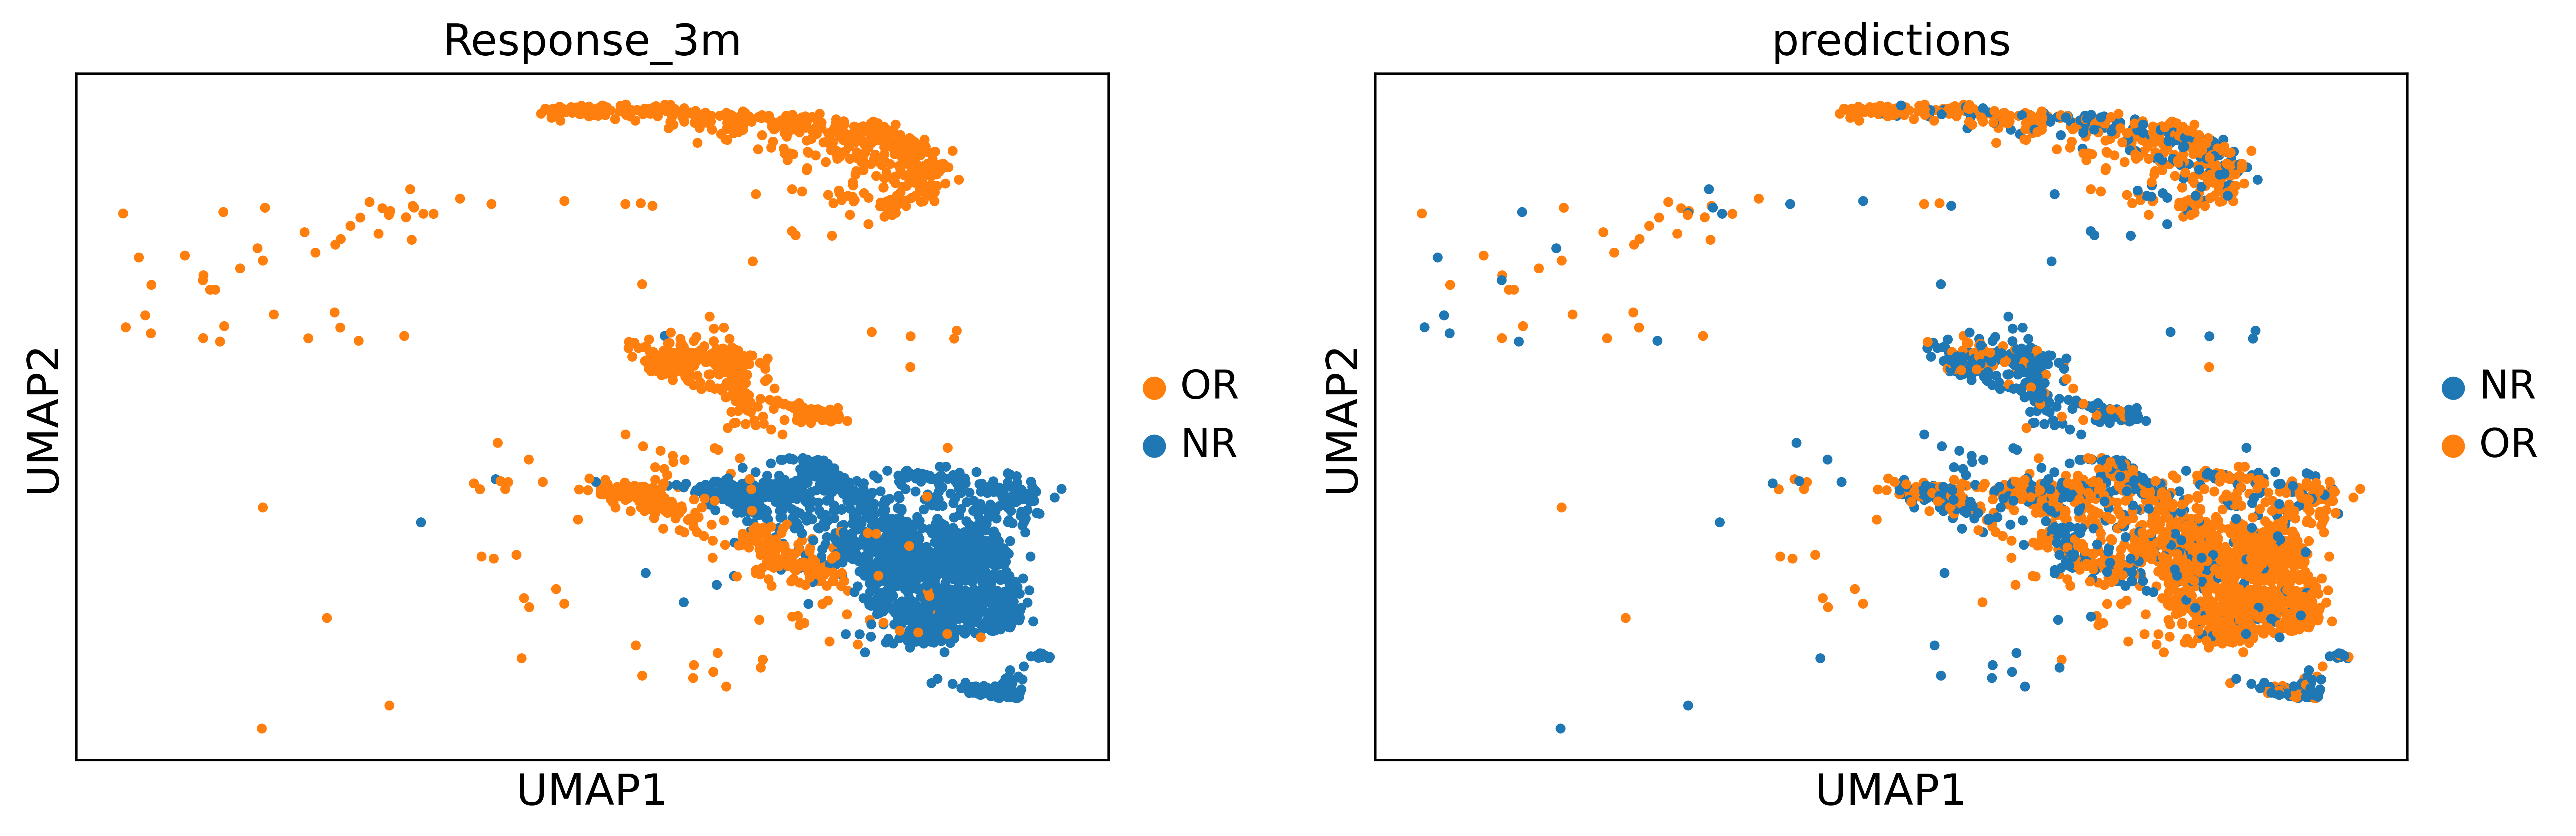

In [ ]:
# ################################## original ################################
# predictions, labels, results = test(best_model, adata_test)
# adata_test_raw.obs["predictions"] = [id2type[p] for p in predictions]

# # plot
# palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] 
# palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
# palette_ = {c: palette_[i] for i, c in enumerate(response)}

# with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (300)}):
#     sc.pl.umap(
#         adata_test_raw,
#         color=["Response_3m", "predictions"],
#         palette=palette_,
#         show=False,
#     )
#     plt.savefig(save_dir / "results.png", dpi=300)

# save_dict = {
#     "predictions": predictions,
#     "labels": labels,
#     "results": results,
#     "id_maps": id2type
# }
# with open(save_dir / "results.pkl", "wb") as f:
#     pickle.dump(save_dict, f)

# results["test/cell_umap"] = wandb.Image(
#     str(save_dir / "results.png"),
#     caption=f"predictions macro f1 {results['test/macro_f1']:.3f}",
# )
# wandb.log(results)

In [ ]:
predictions, labels

(array([1, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 0, 0, 0]))

In [ ]:
label_df = pd.Series(labels)
label_df.unique()
pred_df = pd.Series(predictions)
pred_df.unique()

array([0, 1])

Evaluating: 100%|██████████| 365/365 [00:16<00:00, 22.22it/s]


KeyError: 'test/f1'

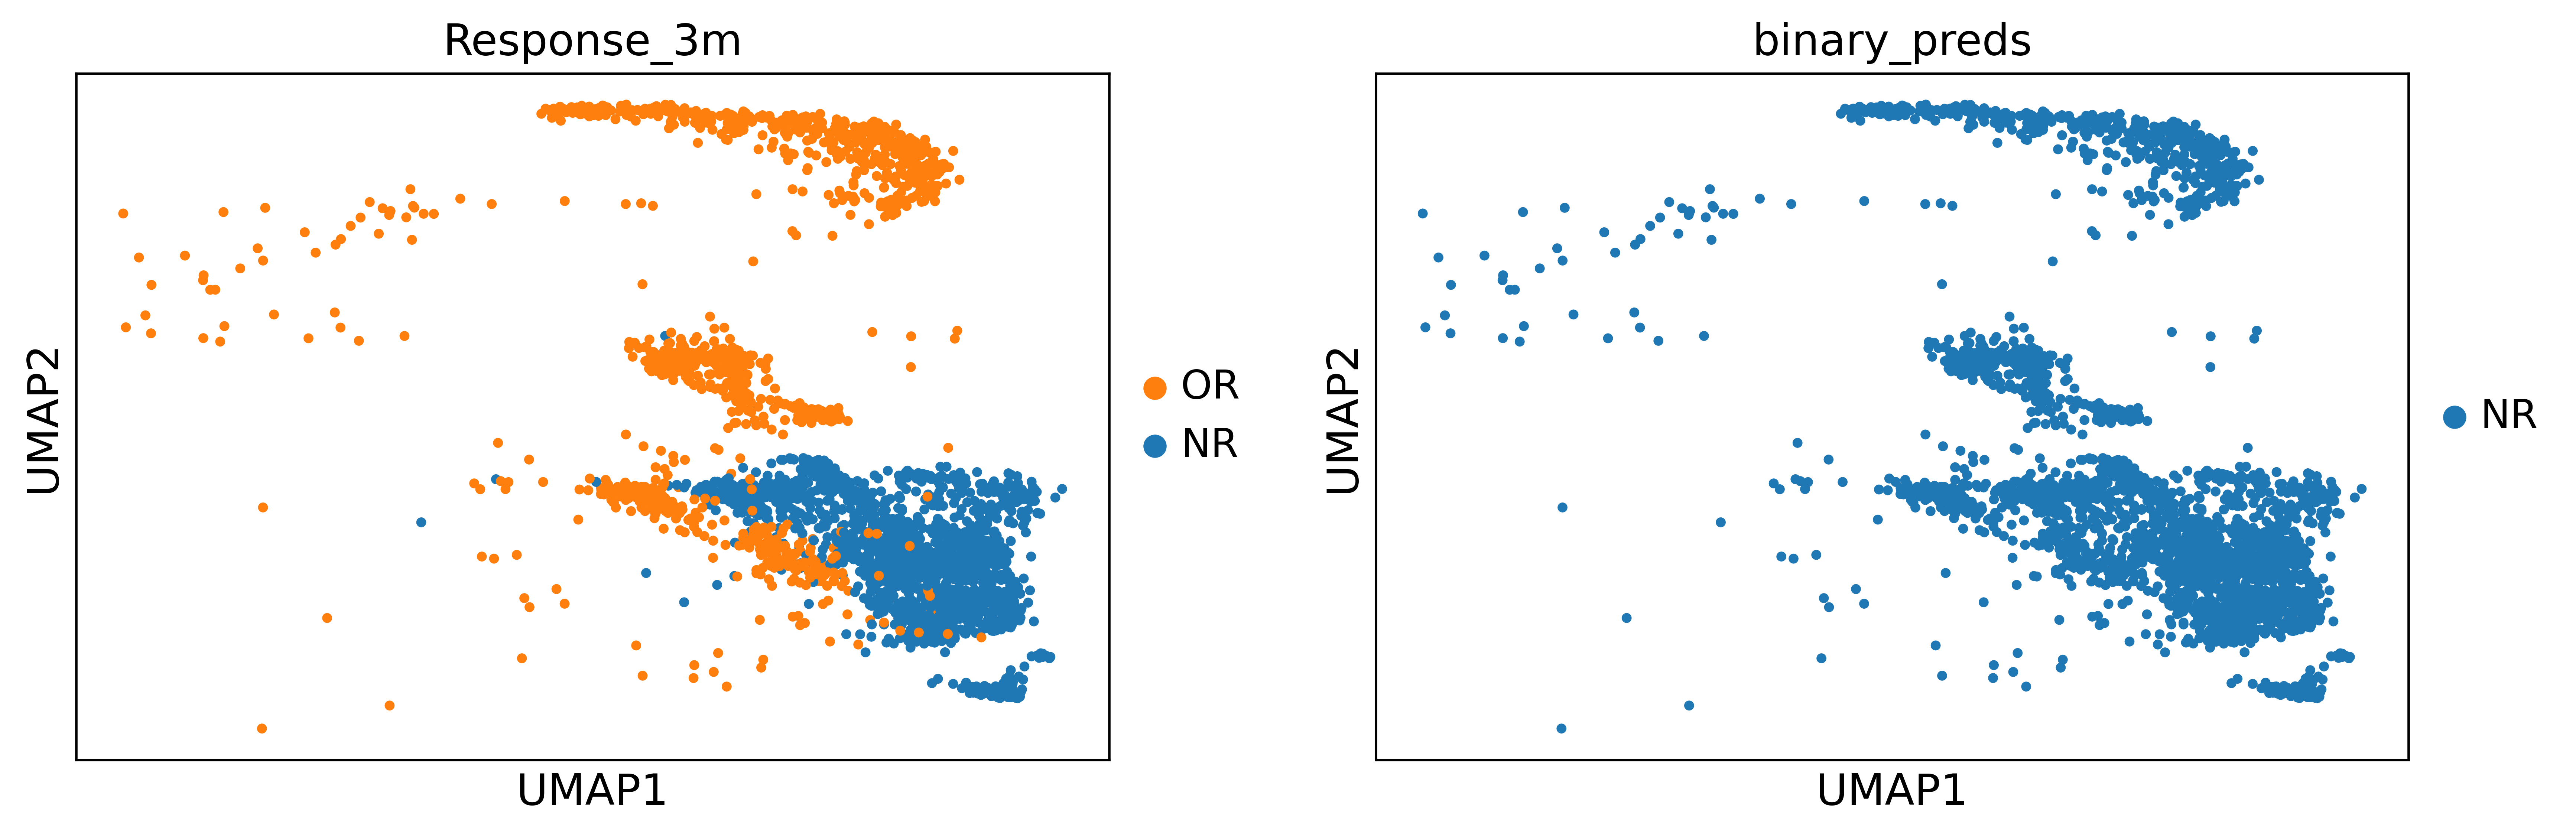

In [50]:
results, response_labels, binary_preds, all_preds = test(best_model, adata_test)
adata_test_raw.obs["binary_preds"] = [id2type[p] for p in binary_preds]

# plot
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] 
palette_ = plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"] + plt.rcParams["axes.prop_cycle"].by_key()["color"]
palette_ = {c: palette_[i] for i, c in enumerate(response)}

with plt.rc_context({"figure.figsize": (6, 4), "figure.dpi": (300)}):
    sc.pl.umap(
        adata_test_raw,
        color=["Response_3m", "binary_preds"],
        palette=palette_,
        show=False,
    )
    plt.savefig(save_dir / "results.png", dpi=300)

save_dict = {
    "predictions": binary_preds,
    "labels": response_labels,
    "results": results,
    "id_maps": id2type
}
with open(save_dir / "results.pkl", "wb") as f:
    pickle.dump(save_dict, f)

results["test/cell_umap"] = wandb.Image(
    str(save_dir / "results.png"),
    caption=f"predictions f1 {results['test/f1']:.3f}",
    
)
wandb.log(results)

In [43]:
# plot ROC curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
y_pred = results["all_preds"]
y_true = results["response_labels"]
RocCurveDisplay.from_predictions(y_true, y_pred)
plt.show()

KeyError: 'response_labels'

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [48]:
gt = pd.Series(labels).map(id2type)
gt.value_counts()

NR    1670
OR    1249
Name: count, dtype: int64

In [49]:
binary_preds

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
predictions

array([0.5551338, 0.5551338, 0.5551338, ..., 0.5551338, 0.5551338,
       0.5551338], dtype=float32)

In [ ]:
results

{'test/accuracy': 0.4222043443282381,
 'validation_loss': 0.7164905942742708,
 'cm': array([[   0, 3591],
        [   0, 2624]]),
 'test/f1': 0.5937323226609345,
 'test/cell_umap': <wandb.sdk.data_types.image.Image at 0x7f0af021bb50>}

In [ ]:
adata.obs.Response_3m.value_counts()    

Response_3m
OR    10536
NR     8315
Name: count, dtype: int64

In [ ]:
8315/10536

0.7891989369779803

In [ ]:
predictions

array([0.5671576, 0.5671576, 0.5671576, ..., 0.5671576, 0.5671576,
       0.5671576], dtype=float32)

In [51]:
results

{'test/accuracy': 0.5721137375813635,
 'validation_loss': 0.6909490990164999,
 'cm': array([[   0, 1249],
        [   0, 1670]]),
 'test/f1': 0.7278274133798213,
 'test/cell_umap': <wandb.sdk.data_types.image.Image at 0x7fa60fcf73d0>,
 'test/confusion_matrix': <wandb.sdk.data_types.image.Image at 0x7fa60e5db4f0>}

In [ ]:
results

{'test/accuracy': 0.3381294964028777,
 'test/precision': 0.3452787672683282,
 'test/recall': 0.35848247460243643,
 'test/macro_f1': 0.33279526385280467,
 'test/cell_umap': <wandb.sdk.data_types.image.Image at 0x7f441d0b75b0>,
 'test/confusion_matrix': <wandb.sdk.data_types.image.Image at 0x7f441b76c220>}

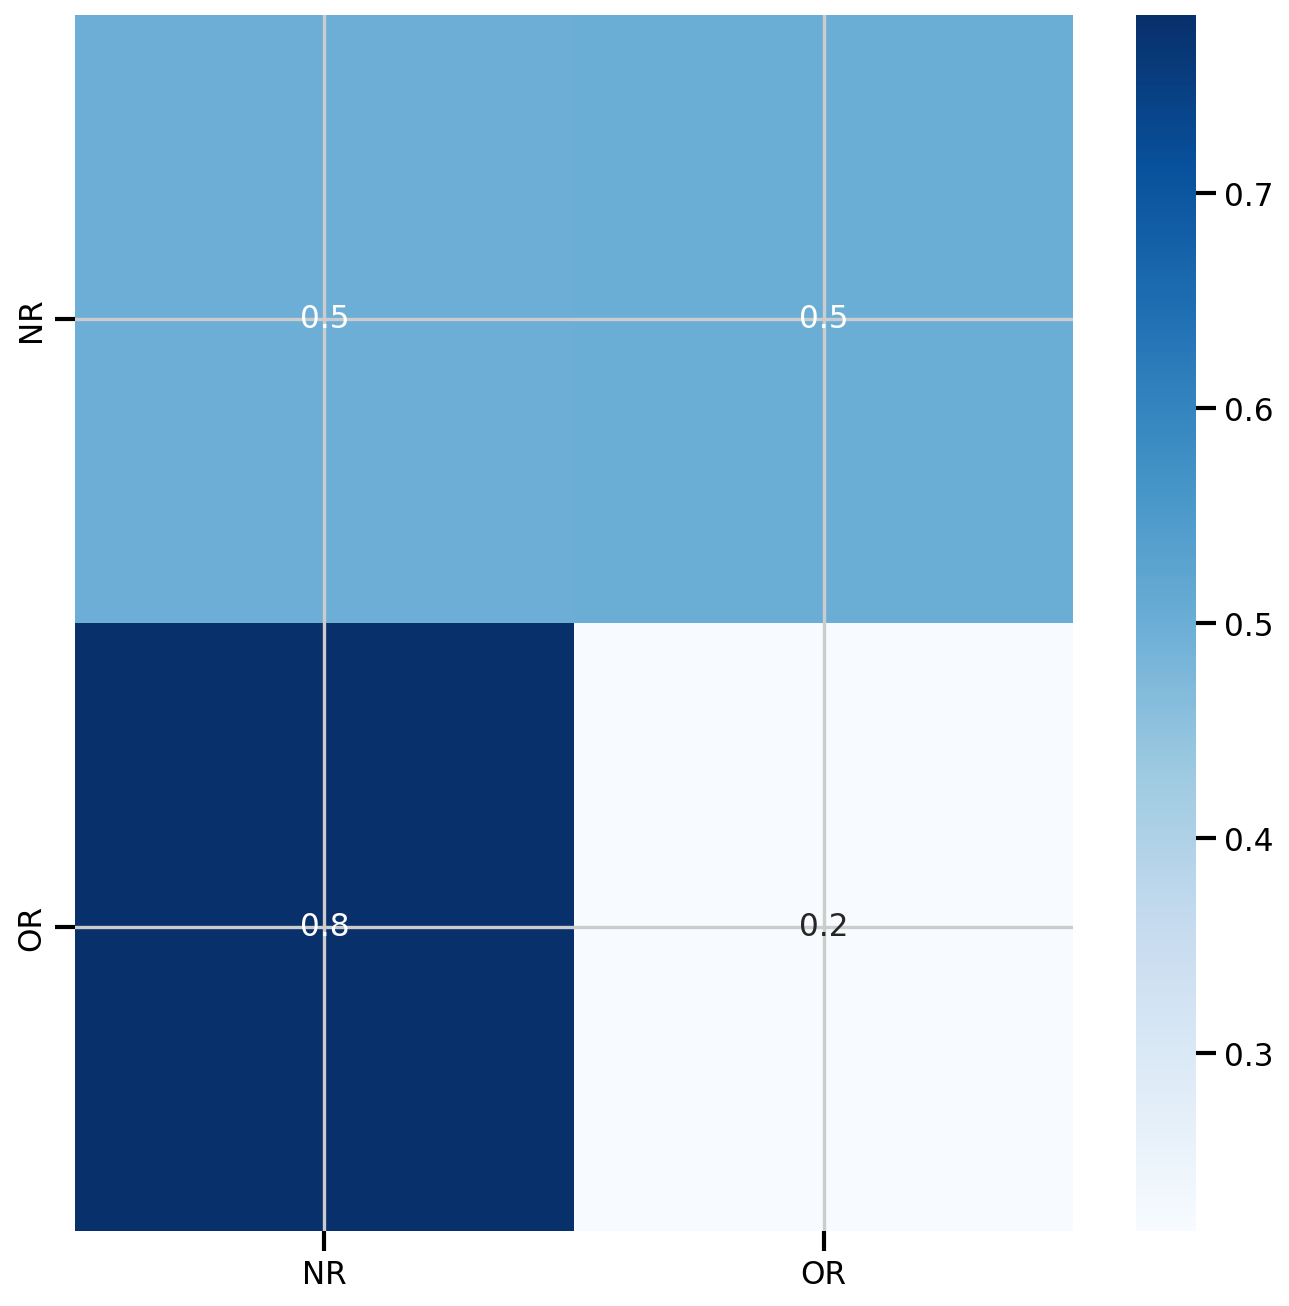

In [ ]:
########################## original ############################
from sklearn.metrics import confusion_matrix
response = list(response)
for i in set([id2type[p] for p in predictions]):
    if i not in response:
        response.remove(i)
cm = confusion_matrix(labels, predictions)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=response[:cm.shape[0]], columns=response[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)

results["test/confusion_matrix"] = wandb.Image(
    str(save_dir / "confusion_matrix.png"),
    caption=f"confusion matrix",
)

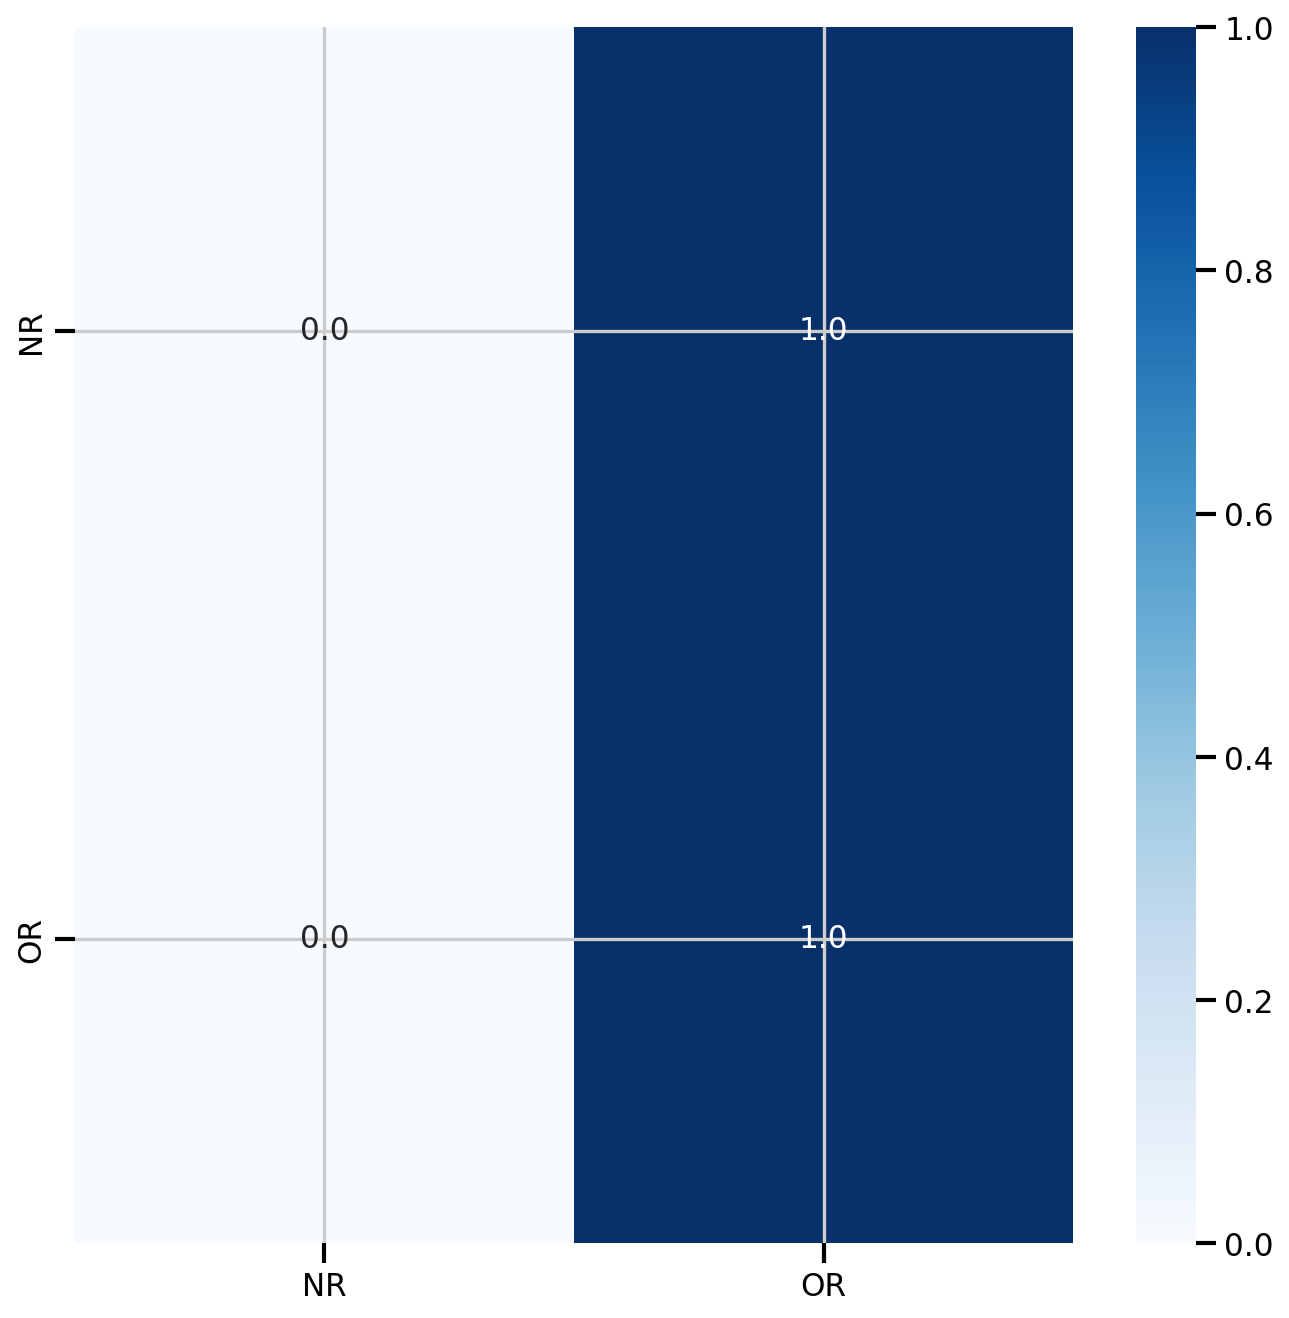

In [50]:
from sklearn.metrics import confusion_matrix
response = list(response)
for i in set([id2type[p] for p in binary_preds]):
    if i not in response:
        response.remove(i)
cm = confusion_matrix(labels, binary_preds)
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = pd.DataFrame(cm, index=response[:cm.shape[0]], columns=response[:cm.shape[1]])
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues")
plt.savefig(save_dir / "confusion_matrix.png", dpi=300)

results["test/confusion_matrix"] = wandb.Image(
    str(save_dir / "confusion_matrix.png"),
    caption=f"confusion matrix",
)

In [ ]:
# save the model into the save_dir
torch.save(best_model.state_dict(), save_dir / "model.pt")